!pip install fbprophet

### 1. 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

import itertools

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [2]:
# 그래프 내 한글 깨짐

import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

### 2. 데이터 불러오기

In [3]:
# 데이터 불러오기
df = pd.read_csv('../Raw 데이터/자동차부품(742)_수출입통계_시계열용 (2011~2021).csv')

# 사용할 데이터만 남기기 (시점, 수출액, 수입액)
df = df.loc[1:]
df.rename(columns=df.iloc[0], inplace=True)
df = df.drop(df.index[0])
df = df[['년월', '수출 금액', '수입 금액']] # 필요한 열만 사용

df.columns = ['시점', '수출액', '수입액']
df.reset_index(drop=True, inplace=True)

# 날짜데이터 변환 (월별 데이터이므로 가장 마지막날로 설정)
df['시점'] = pd.date_range('2011-01-31', periods=132, freq='M')
df

,시점,수출액,수입액
0,2011-01-31,1770908,521846
1,2011-02-28,1697007,447911
2,2011-03-31,2044642,597860
3,2011-04-30,1984151,526234
4,2011-05-31,1882387,547208
...,...,...,...
127,2021-08-31,1579116,507368
128,2021-09-30,1853552,500444
129,2021-10-31,1784922,495623
130,2021-11-30,1841532,477131


In [4]:
# 수출액, 수입액: 수치형으로 변환
df['수출액']=df['수출액'].astype(float)
df['수입액']=df['수입액'].astype(float)

In [5]:
# Null 값, Data 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   시점      132 non-null    datetime64[ns]
 1   수출액     132 non-null    float64       
 2   수입액     132 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.2 KB


In [6]:
data_pn = df[['시점', '수입액']]
data_pn = data_pn.set_index('시점')
data_pn

,수입액
시점,
2011-01-31,521846.0
2011-02-28,447911.0
2011-03-31,597860.0
2011-04-30,526234.0
2011-05-31,547208.0
...,...
2021-08-31,507368.0
2021-09-30,500444.0
2021-10-31,495623.0


### 3. ARIMA 모델링

#### (1) 수입액 변화 추이 시각화해서 살펴보기

Text(0.5, 1.0, '자동차부품 년도별 수입액 변화 추이 (단위: 천 달러)')

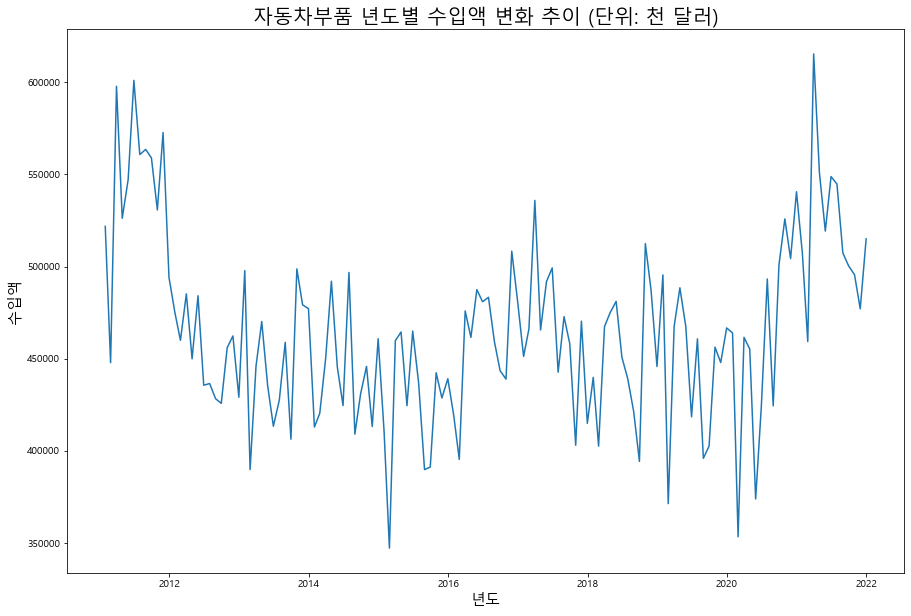

In [8]:
# 수입액 변화 추이
plt.figure(figsize=(15, 10))
plt.plot(data_pn)
plt.xlabel('년도', fontsize=15)
plt.ylabel('수입액', fontsize=15)
plt.title('자동차부품 년도별 수입액 변화 추이 (단위: 천 달러)', fontsize=20)

#### (2) 정상성(stationary) 확인하고 차분하기

- 정상성 : 평균, 분산이 시간에 따라 일정한 성질 (비정상성인 데이터는 정상성을 가질 수 있도록 로그변환 또는 차분 진행)


- 참고 : https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80

In [9]:
# AD-Fuller Test : 시계열의 정상성(stationary) 한지 확인

from statsmodels.tsa.stattools import adfuller

# 차분 : 현 시점 데이터에서 d 시점 이전 데이터를 뺀 것
data_pn_diff = data_pn - data_pn.shift(1) # ex) 2011년 2월 데이터 - 2011년 1월 데이터
print(data_pn_diff)
print('-------------------------------------------')

y = data_pn.dropna()
y1diff = data_pn_diff.dropna()

result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
print('-------------------------------------------')

result = adfuller(y1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

                 수입액
시점                  
2011-01-31       NaN
2011-02-28  -73935.0
2011-03-31  149949.0
2011-04-30  -71626.0
2011-05-31   20974.0
...              ...
2021-08-31  -37463.0
2021-09-30   -6924.0
2021-10-31   -4821.0
2021-11-30  -18492.0
2021-12-31   37954.0

[132 rows x 1 columns]
-------------------------------------------
원 데이터 ADF Statistic: -3.155
원 데이터 p-value: 0.023
-------------------------------------------
1차 차분 ADF Statistic: -3.535
1차 차분 p-value: 0.007


`시계열 분석을 하기 위해서는 기본적으로 시계열이 '정상성'을 만족해야한다. 그리고 일반적으로 ADF Test 결과 p-value가 0.05보다 작으면 정상성이 있다고 볼 수 있다. 이에 따라, 원데이터와 1차 차분한 결과가 정상성이 있으므로, 원데이터와 차분모델은 정상성의 가정을 만족한다.`

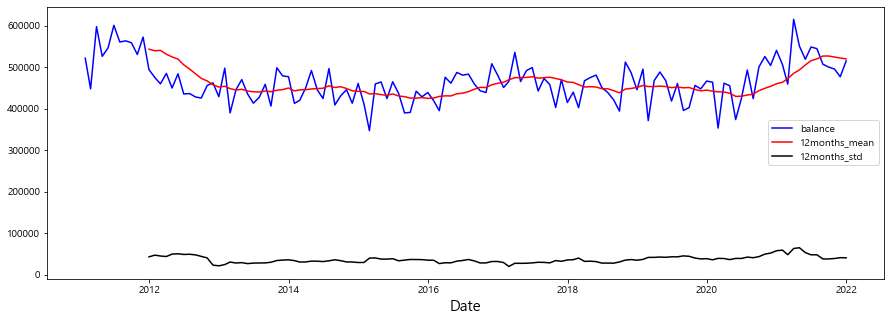

In [10]:
# 수출액 이동 평균, 이동 표준편차 그래프
data_pn_mean = data_pn.rolling(window=12).mean()
data_pn_std = data_pn.rolling(window=12).std()

plt.figure(figsize=(15, 5))
plt.xlabel('Date', fontsize=15)
orig = plt.plot(df['시점'], data_pn, color='blue', label='balance')
mean = plt.plot(df['시점'], data_pn_mean, color='red', label='12months_mean')
std = plt.plot(df['시점'], data_pn_std, color='black', label='12months_std')
plt.legend(loc='best')
plt.show()

# rolling : 이동평균계산
# rolling(window=12).mean()의 경우, 12개 평균냄
# 즉, 데이터가 12번째 이후인 값들부터 출력

`(보류) 12개월을 기준으로 이동평균선을 그려본 결과, 코로나 19가 발생한 시점인 2020년 상반기부터 자동차부품 산업의 수출액이 감소하고 있는 동향을 확인할 수 있다. 그리고 2021년 하반기부터 수출액이 증가하고 있음을 확인할 수 있다.`

#### (3) p, d, q 파라미터 추정

**이동평균 모형 (MA)**

- 과거로부터 현재까지의 시계열 자료를 대상으로 일정기간별 이동평균을 계산하고, 이들의 추세를 파악하여 다음 기간을 예측하는 법
- 시계열 자료에서 계절변동과 불규칙 변동을 제거해 추세변동과 순환변동만 가진 시계열로 변환하는 방법으로 사용

**자기회귀 모형 (AR)**
- p 시점 전의 자료가 현재 자료에 영향을 주는 모형

- `AR 모형` : 자기회귀모형, 이전 관측값의 오차항이 이후 관측값에 영향
- `MA 모형` : 이동평균모형, 관측값이 이전의 연속적인 오차항의 영향
- `ARIMA(p, d, q) 모형` : d차 차분한 데이터에 AR(p)모형과 MA(q)모형을 합친 모형


    - 따라서, AR(p) = ARIMA(p, 0, 0)이고, MA(q) = ARIMA(0, 0, q)
    - 여기서 p와 q는 ACF 그래프와 PACF 그래프를 그려서 확인
    - AR은 PACF, MA는 ACF

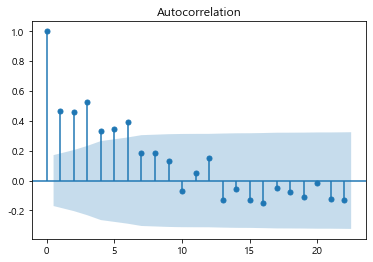

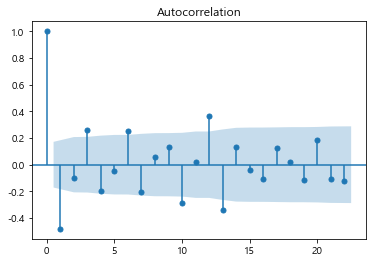

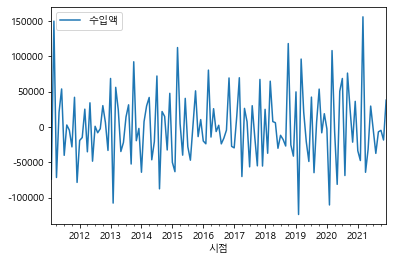

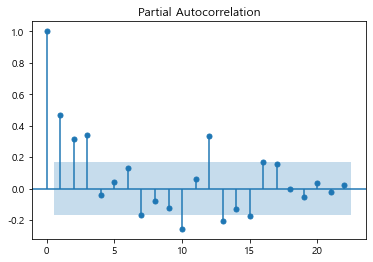

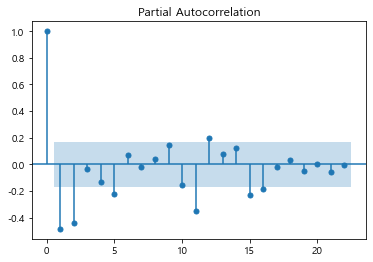

In [11]:
# 12개월 이동평균선을 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 이동평균모형 (MA)
plot_acf(y)
plot_acf(y1diff)
plt.show()

# 1차 차분 시계열 그래프
diff_1 = y.diff(periods=1).iloc[1:]
diff_1.plot()

# 자기회귀모형 (AR)
plot_pacf(y)
plot_pacf(y1diff)
plt.show()

보통은 위의 그래프를 이용해서 정함. 그리고 아래 코드도 그렇게 정한 것. 하지만 여기서는 AIC 기준으로 최적의 차수를 정해보도록 할 것

In [12]:
# # 조금 더 객관적으로 파라미터 찾기 (안됨...)

# p = range(0, 3)
# d = range(1, 2)
# q = range(0, 3)
# pdq = list(itertools.product(p, d, q))

# aic = []
# for i in pdq:
#     model = ARIMA(data_pn.values, order=(i))
#     model_fit = model.fit()
#     print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
#     aic.append(round(model_fit.aic, 2))
    
# # 최적의 파라미터 찾기

# optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
# optimal

In [21]:
def my_auto_arima(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
        
                result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
                result_df.sort_values(sort, inplace=True)
    return result_df

my_auto_arima(data_pn,[3,2,3])

C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M wil

,order,AIC
15,p2 d1 q0,3156.219981
16,p2 d1 q1,3158.017667
4,p0 d1 q1,3158.048809
17,p2 d1 q2,3158.154798
5,p0 d1 q2,3159.154900
10,p1 d1 q1,3159.417997
11,p1 d1 q2,3161.622332
8,p1 d0 q2,3180.469284
7,p1 d0 q1,3180.570647
13,p2 d0 q1,3181.334583


`(p, d, q)가 (2, 1, 0)일 때, AIC의 값이 가장 작으므로 해당 파라미터 값을 사용 : ARIMA(2, 1, 0)`

#### (4) ARIMA 모델링 진행

C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M wil

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  131
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1574.112
Method:                       css-mle   S.D. of innovations          39914.122
Date:                Wed, 30 Mar 2022   AIC                           3154.223
Time:                        23:57:34   BIC                           3162.849
Sample:                    02-28-2011   HQIC                          3157.728
                         - 12-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.6929      0.078     -8.840      0.000      -0.847      -0.539
ar.L2.D.y     -0.4470      0.081     -5.550      0.000      -0.605      -0.289
                                    Roots           

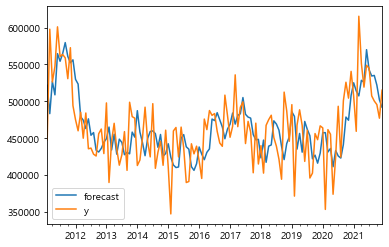

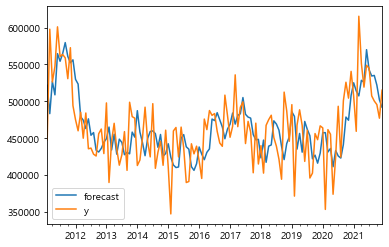

In [19]:
# ARIMA 모델 학습 후 계수가 유의한지 검정

data_pn = data_pn.sort_index(ascending=True)
data_pn = data_pn.dropna()

model = ARIMA(data_pn.values, order = (2,1,0), dates=(data_pn.index))

# 모델 학습
model_fit = model.fit(trend='nc',full_output=True, disp=True)
print(model_fit.summary())

# 모델 예측
model_fit.plot_predict()

**ARIMA 모델 학습 후 계수가 유의한지 검정**

- AIC : 주어진 데이터셋에 대한 통계 모델의 상대적인 품질을 평가하는 것
- AIC 값은 낮을수록 좋다 (주관적으로 선택하는 부분이라 for문 돌려서 AIC 값이 가장 낮게 나오는 모델을 선택하는 것을 추천)

`p-value 값도 유의미하고, AIC 값도 제일 낮아 임의로 값을 주었을 때보다 더 성능이 좋은 모델임을 예측가능`

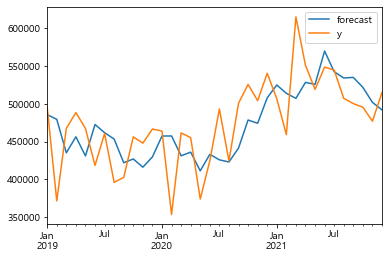

In [15]:
# 위에서는 얼핏 비슷해보이는데 실제로 그런지 확대해서 살펴봄
model_fit.plot_predict(start=datetime.datetime(2019,1,31))
plt.show()

#### (5) ARIMA 모델을 활용하여 Forecast

In [16]:
dada=pd.date_range('2022-1-1', '2023-3-31', freq='M')

C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\phi49\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M wil

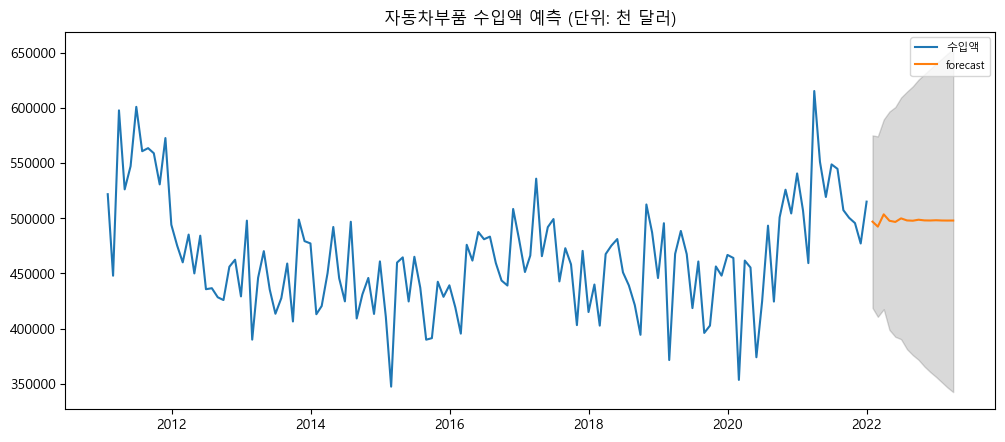

In [20]:
model = ARIMA(data_pn, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=dada)
lower_series = pd.Series(conf[:, 0], index=dada)
upper_series = pd.Series(conf[:, 1], index=dada)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_pn, label='수입액')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('자동차부품 수입액 예측 (단위: 천 달러)')
plt.legend(loc='upper right', fontsize=8)
plt.show()